# What to expect

In notebook 3A we ran a differential gene expression analysis on the example dataset Schistosoma mansoni and used visualisation techniques to view the most significant genes. In this notebook we will apply the same methods to our choice of dataset in this notebook. We will go on to explore the GO terms and pathways associated with them using online resources.



# Differential Expression analysis

In [10]:
import pandas as pd
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

# load in the counts and metadata again
prefix = "Trypanosoma"
counts = pd.read_csv(f"analysis/{prefix}/star/ReadsPerGene.csv", index_col=0).T
metadata = pd.read_csv(f"data/{prefix}/metadata.csv", index_col=0)
counts.fillna(0)

# restrict to the 2 stages we want to compare
counts_s = counts[metadata["organism"].isin(["Trypanosoma brucei brucei"])]
counts_s = counts_s.loc[:, (counts_s != 0).any(axis=0)]
metadata_s = metadata[metadata["organism"].isin(["Trypanosoma brucei brucei"])]

# create deseq2 dataset object
dds = DeseqDataSet(
    counts=counts_s,
    metadata=metadata_s,
    design_factors="morphology",  # compare samples based on the developmental "morphology"
    refit_cooks=True
)

# Run DeSeq2
dds.deseq2()

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.30 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 1.31 seconds.

Fitting LFCs...
... done in 0.85 seconds.

Replacing 0 outlier genes.



In [11]:
# Summarize results
stat_res=DeseqStats(dds)
stat_res.summary()
res = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: morphology stumpy vs slender
                                  baseMean  log2FoldChange     lfcSE  \
gene                                                                   
Tb04.24M18.150                  197.292416        0.217076  0.190113   
Tb04.3I12.100                   218.408392        0.124410  0.171733   
Tb05.30F7.410                    99.278007       -1.824686  0.655682   
Tb05.5K5.100                     16.771503        0.644534  0.566149   
Tb05.5K5.110                    329.781049       -0.045490  0.139745   
...                                    ...             ...       ...   
Tb927_10_v4.snoRNA.0063:snoRNA    3.790393        0.122766  1.088592   
Tb927_10_v4.snoRNA.0064:snoRNA    0.153151        0.709747  4.425350   
Tb927_10_v4.snoRNA.0073:snoRNA    0.183423       -1.213827  4.425356   
Tb927_10_v4.snoRNA.0078:snoRNA  133.952072        0.242593  0.196926   
tmp.1.100                        48.341400        0.781146  0.795903 

... done in 0.54 seconds.



In [12]:
! mkdir -p "analysis/Trypanosoma/de"
! mkdir -p "analysis/Plasmodium/de"

In [13]:
# save this intermediate CSV with a sensible name
comparison = "slender_vs_stumpy_tbrucei"
res.to_csv(f"analysis/{prefix}/de/{comparison}.full.csv")

In [14]:
# Filter results with baseMean<10 so that gene expressions close to zero don't skew results
res=res[res.baseMean>=10]

# Filter by padj<=0.05
res=res[res.padj<=0.05]

In [15]:
# Get list of only genes that have a fold change FC > 2 or FC < 0.5 
# You can play with the exact thresholds here, these are just a guide to filter the lists
sigs=res[abs(res.log2FoldChange)>0.5]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
Tb05.30F7.410,99.278007,-1.824686,0.655682,-2.782883,5.387819e-03,1.328643e-02
Tb05.5K5.130,704.934698,-0.628927,0.130879,-4.805425,1.544232e-06,7.284318e-06
Tb05.5K5.150,356.075307,-0.569119,0.144164,-3.947713,7.890143e-05,2.829485e-04
Tb05.5K5.210,652.756184,-0.546718,0.123308,-4.433774,9.259770e-06,3.895142e-05
Tb05.5K5.270,559.894678,2.175802,0.136340,15.958660,2.479999e-57,3.030820e-55
...,...,...,...,...,...,...
Tb927.9.9820,1610.596099,-1.227299,0.095700,-12.824474,1.195962e-37,6.732177e-36
Tb927.9.9840,1142.358426,-0.682270,0.133585,-5.107371,3.266722e-07,1.695045e-06
Tb927.9.9870,1282.657306,-0.712261,0.095791,-7.435564,1.041227e-13,1.170813e-12


In [16]:
# Save the up and down regulated genes separately
up = sigs[sigs["log2FoldChange"] > 0]
up.to_csv(f"analysis/{prefix}/de/{comparison}.up.csv")
up

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
Tb05.5K5.270,559.894678,2.175802,0.136340,15.958660,2.479999e-57,3.030820e-55
Tb05.5K5.70,711.309715,0.849127,0.114786,7.397470,1.388035e-13,1.532945e-12
Tb08.27P2.60,34.502243,1.439497,0.489139,2.942921,3.251311e-03,8.477871e-03
Tb08.27P2.90,45.643900,1.285695,0.365525,3.517398,4.358000e-04,1.367470e-03
Tb09.v4.0150,900.439292,0.607229,0.126354,4.805780,1.541491e-06,7.278052e-06
...,...,...,...,...,...,...
Tb927.9.9300,2943.061947,1.205118,0.080100,15.045153,3.714757e-51,3.709963e-49
Tb927.9.9410,1057.658097,1.239115,0.099400,12.465954,1.144940e-35,5.842969e-34
Tb927.9.9600,2503.524120,0.536295,0.081745,6.560552,5.360898e-11,4.547216e-10


In [17]:
down = sigs[sigs["log2FoldChange"] < 0]
up.to_csv(f"analysis/{prefix}/de/{comparison}.down.csv")
down

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene,,,,,,
Tb05.30F7.410,99.278007,-1.824686,0.655682,-2.782883,5.387819e-03,1.328643e-02
Tb05.5K5.130,704.934698,-0.628927,0.130879,-4.805425,1.544232e-06,7.284318e-06
Tb05.5K5.150,356.075307,-0.569119,0.144164,-3.947713,7.890143e-05,2.829485e-04
Tb05.5K5.210,652.756184,-0.546718,0.123308,-4.433774,9.259770e-06,3.895142e-05
Tb05.5K5.280,501.262274,-1.617947,0.146906,-11.013489,3.290096e-28,1.123471e-26
...,...,...,...,...,...,...
Tb927.9.9810,1413.470872,-1.451264,0.100924,-14.379708,6.938656e-47,6.256917e-45
Tb927.9.9820,1610.596099,-1.227299,0.095700,-12.824474,1.195962e-37,6.732177e-36
Tb927.9.9840,1142.358426,-0.682270,0.133585,-5.107371,3.266722e-07,1.695045e-06


# Visualisation - Volcano Plot
Following the steps from notebook 3A, create a volcano plot for this dataset, colouring the significant up and down regulated genes. If you chose a different fold change cut off above, use the updated fold change here so you can see which genes are selected for. If desired, you could instead make it interactive with plotly (see extension in 3A).

/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_86538/270656339.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
/var/folders/qt/xlbr5yjj3w5ddjw5k6g120zc0000gp/T/ipykernel_86538/270656339.py:10: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=1,label="Down-regulated",color="blue")


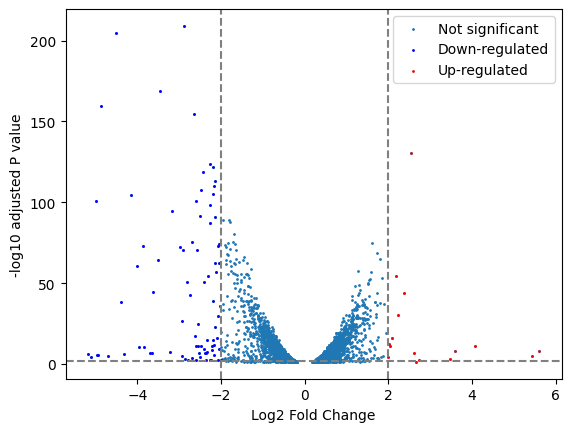

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt

down = res[(res['log2FoldChange']<=-2)&(res['padj']<0.05)]
up = res[(res['log2FoldChange']>=2)&(res['padj']<0.05)]

# plot the all the genes and then highlight downregulated and upregulated
plt.scatter(x=res['log2FoldChange'],y=res['padj'].apply(lambda x:-np.log10(x)),s=1,label="Not significant")
plt.scatter(x=down['log2FoldChange'],y=down['padj'].apply(lambda x:-np.log10(x)),s=1,label="Down-regulated",color="blue")
plt.scatter(x=up['log2FoldChange'],y=up['padj'].apply(lambda x:-np.log10(x)),s=1,label="Up-regulated",color="red")

#Add axis labels
plt.xlabel("Log2 Fold Change")
plt.ylabel("-log10 adjusted P value")

# Add threshold lines
plt.axvline(-2,color="grey",linestyle="--")
plt.axvline(2,color="grey",linestyle="--")
plt.axhline(2,color="grey",linestyle="--")
plt.legend()

plt.savefig('dataset_volcano.png')

# GO Analysis and Metabolic pathways analysis

We will now use these results for GO and metabolic pathway analysis using the TriTrypDB and PlasmoDB websites. Full details of how to do this are in the presentation, but a summary is provided below.

You are welcome to perform either GO or metabolic pathway analysis on your chosen dataset, or both if you have time.

For these analyses you will need either a text list of gene IDs which can be pasted into the website field, or by uploading a text file. You should create a separate list for up regulated and down regulated genes for this.

## GO Analysis
For this you will need either a text list of gene IDs which can be pasted into the website field, or by uploading a text file. The DBs return a .csv file that includes the names (other annotations, such as cellular locations or GO terms, can be included, if desired):

https://tritrypdb.org/tritrypdb/app/search/transcript/GeneByLocusTag
https://plasmodb.org/plasmo/app/search/transcript/GeneByLocusTag

After adding the list of gene IDs, click "Get Answer". When the results table appears, there will be a tab called "Analyze Results". From this you will be able to select either "Gene Ontology Enrichment" or "Metabolic Pathway Enrichment". Select the GO analysis.

The results can be downloaded as a .csv file, and the results filtered by (p-value or) bonferroni adjusted p-value.

## Metabolic Pathways
Similarly to above, you will need either a text list of gene IDs, this time for ‘up’ and ‘down’ separately. This can be submitted to the respective DB tools for metabolic pathway analysis:

https://tritrypdb.org/tritrypdb/app/search/pathway/PathwaysByGeneList
https://plasmodb.org/plasmo/app/search/pathway/PathwaysByGeneList

After adding the list of gene IDs, click "Get Answer". The search function offers a few different ‘Pathway Sources’ (KEGG, LeishCyc, MetaCyc and TrypanoCyc for T. brucei). Start with "Any" and include all of them, the hit list can be subsequently filtered by source, if desired.

Pathways with hits can be downloaded as .csv file, and the results can be customized in terms of the columns that should be included, such as ‘Total Pathway Enzymes’, ‘Unique Gene Counts’ (i.e. hits in that pathway), EC numbers etc.